In [1]:
import sys
sys.path.append("../")
sys.path.append("../..")

import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(14, 4)

In [2]:
# Input
start_time = pd.to_datetime("2021-01-25 00:00:00")
end_time = pd.to_datetime("2021-02-10 00:00:00")

durationList = ['Hour', 'Day', 'Week', 'Month','Year']
feature_cycle = 'Day'
feature_cycle_times = 1

fig_width_num = 4
fig_width = 30
fig_height = 30
duration = {'start_time':start_time, 'end_time':end_time}

modelName="som"
db_name = 'air_indoor_경로당'
ms_name = 'ICL1L2000241'

feature_name = 'in_co2'
freq_min = 60
import datetime
timedelta_frequency_min = datetime.timedelta(minutes= freq_min)

# 3. Nan Processing Parameter
# 3-1. NanLImitProcessingInfo = {'type':'ratio', 'ConsecutiveNanLimit':0.05, 'totalNaNLimit':1} # seconds
# 3-2. NanLImitProcessingInfo = {'type':'time', 'ConsecutiveNanLimit':1*60*60, 'totalNaNLimit':5*60*60} #seconds
# 3-3.
#NanInfoForCleanData = {'type':'num', 'ConsecutiveNanLimit':2, 'totalNaNLimit':20} #27
#NanInfoForCleanData = {'type':'num', 'ConsecutiveNanLimit':1000, 'totalNaNLimit':100000}
NanInfoForClenData = {'type':'num', 'ConsecutiveNanLimit':1, 'totalNaNLimit':1} #66

## 1. data Prepration

In [3]:
from clust.ingestion.influx import influx_Client_v2 as influx_Client, bucket_data
from setting import influx_setting_KETI as ins
db_client = influx_Client.influxClient(ins.CLUSTDataServer2)

In [4]:
input_data = db_client.get_data_by_time(start_time, end_time, db_name, ms_name)

In [5]:
from clust.transformation.splitDataByCycle import dataByCycle
# 고른 프리컨시를 갖는 Cycle 데이터가 딕셔너리 형태로 제공됨
dataSet = dataByCycle.getCycleSelectDataSet(input_data, feature_cycle, feature_cycle_times)

## 2. preprocessing (refinement, error handling)

In [6]:
from Clust.clust.preprocessing.custom.simple import preprocessing_basic_for_clust_multiDataSet
from Clust.clust.ingestion.mongo import mongo_Client
mongo_client = mongo_Client.mongoClient(ins.CLUSTMetaInfo2)
#db에서 가져온 데이터로 만든 민맥스
from Clust.clust.ingestion.mongo import customModules
min_max_from_db = customModules.get_min_max_info_from_bucketMeta(mongo_client, db_name)
dataSet_pre = preprocessing_basic_for_clust_multiDataSet(dataSet, min_max_from_db, timedelta_frequency_min)

In [18]:
dataSet_pre

{'2021-01-26 00:00:00':                            in_co2  in_humi  in_noise  in_pm01  in_pm10  \
 time                                                                     
 2021-01-26 00:00:00+00:00     NaN      NaN       NaN      NaN      NaN   
 2021-01-26 01:00:00+00:00     NaN      NaN       NaN      NaN      NaN   
 2021-01-26 02:00:00+00:00     NaN      NaN       NaN      NaN      NaN   
 2021-01-26 03:00:00+00:00     NaN      NaN       NaN      NaN      NaN   
 2021-01-26 04:00:00+00:00     NaN      NaN       NaN      NaN      NaN   
 2021-01-26 05:00:00+00:00     NaN      NaN       NaN      NaN      NaN   
 2021-01-26 06:00:00+00:00     NaN      NaN       NaN      NaN      NaN   
 2021-01-26 07:00:00+00:00     NaN      NaN       NaN      NaN      NaN   
 2021-01-26 08:00:00+00:00     NaN      NaN       NaN      NaN      NaN   
 2021-01-26 09:00:00+00:00     NaN      NaN       NaN      NaN      NaN   
 2021-01-26 10:00:00+00:00     NaN      NaN       NaN      NaN      NaN   
 2

## 3. get one dataframe 

In [7]:
from Clust.clust.transformation.general import dataframe
dataDF = dataframe.get_oneDF_with_oneFeature_from_multipleDF(dataSet_pre, feature_name)

## 4. remove bad column

In [8]:
from Clust.clust.quality.NaN import cleanData
CMS = cleanData.CleanData()
data = CMS.get_cleanData_by_removing_column(dataDF, NanInfoForClenData) 

15 ---> 5


### 4-1 Visualization

In [20]:
for column in dataDF.columns:
    if column in data:
        flag = 1
    else:
        flag = 0 


0
0
0
0
0
0
0
0
0
0
1
1
1
1
1


## 5. Clustering

### 5-1. Preprocessing for clustering

In [10]:
from Clust.clust.preprocessing.custom.simple import preprocessing_smoothing_scaling
data = preprocessing_smoothing_scaling(data, ewm_parameter=0.9)

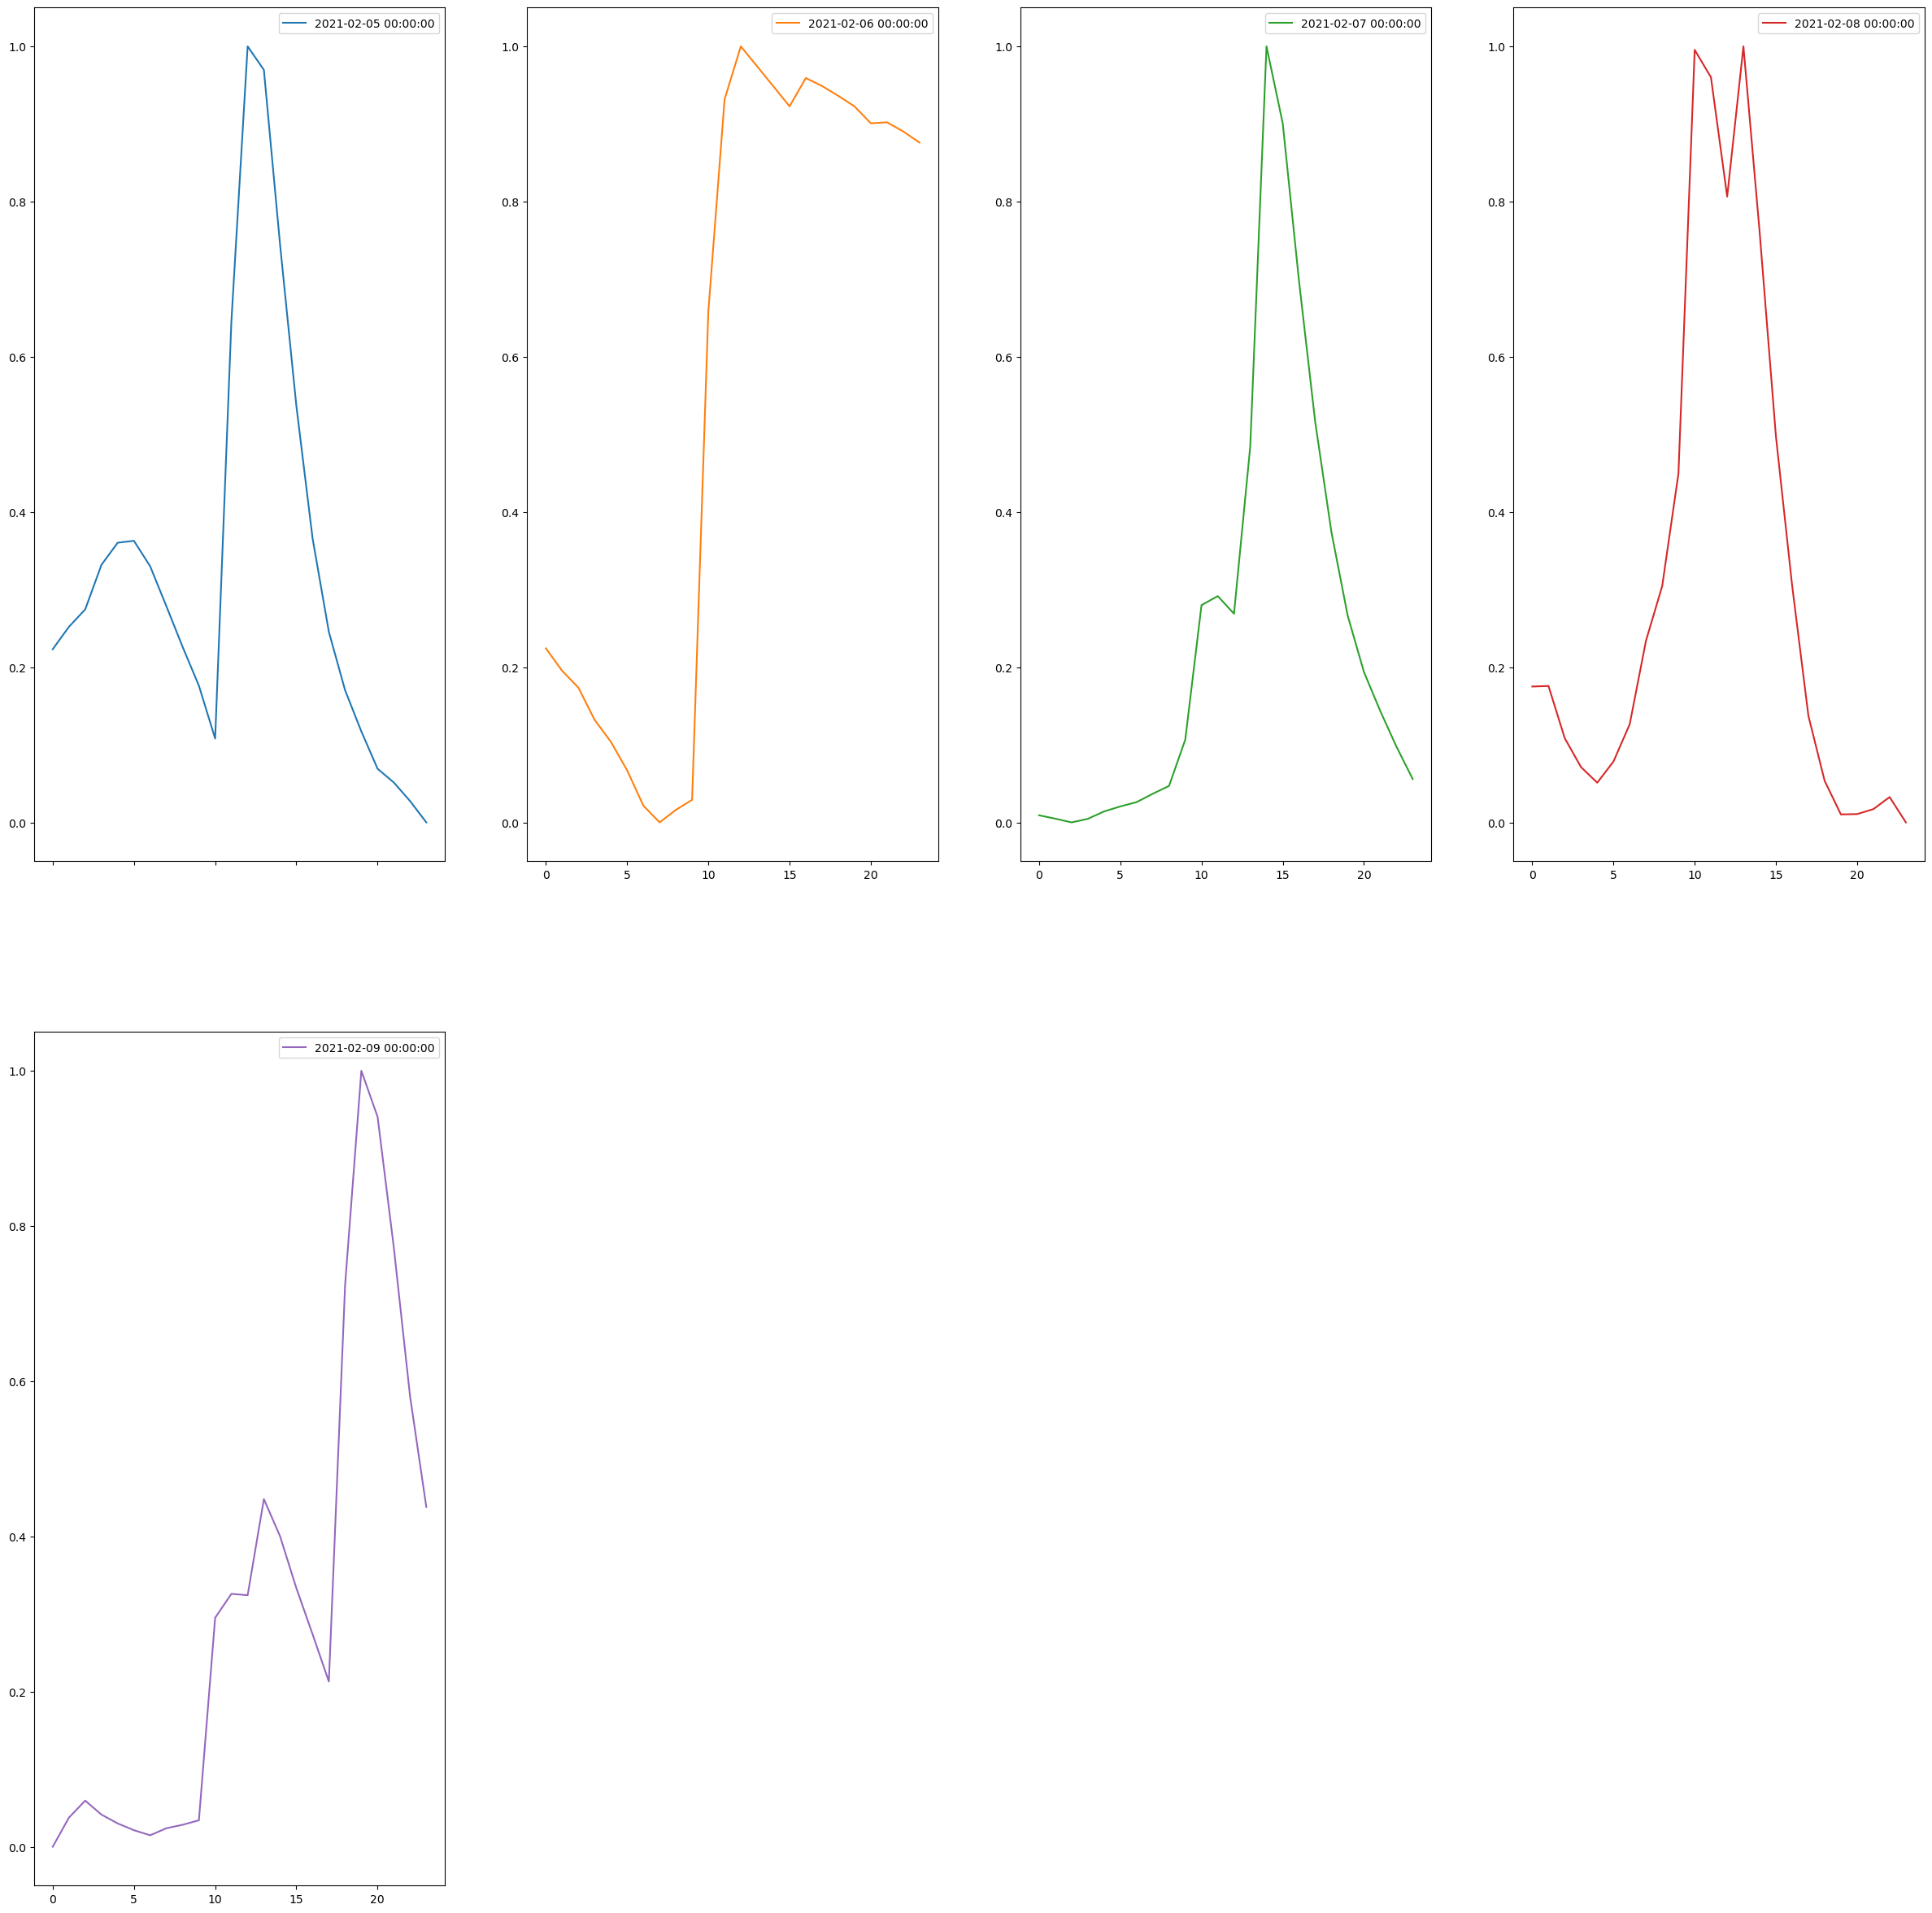

In [11]:
from Clust.clust.tool.plot import plot_features
plot_features.plot_all_column_data_inSubPlot(data, fig_width, fig_height, fig_width_num = 4)

### 5-2. Som Clustering

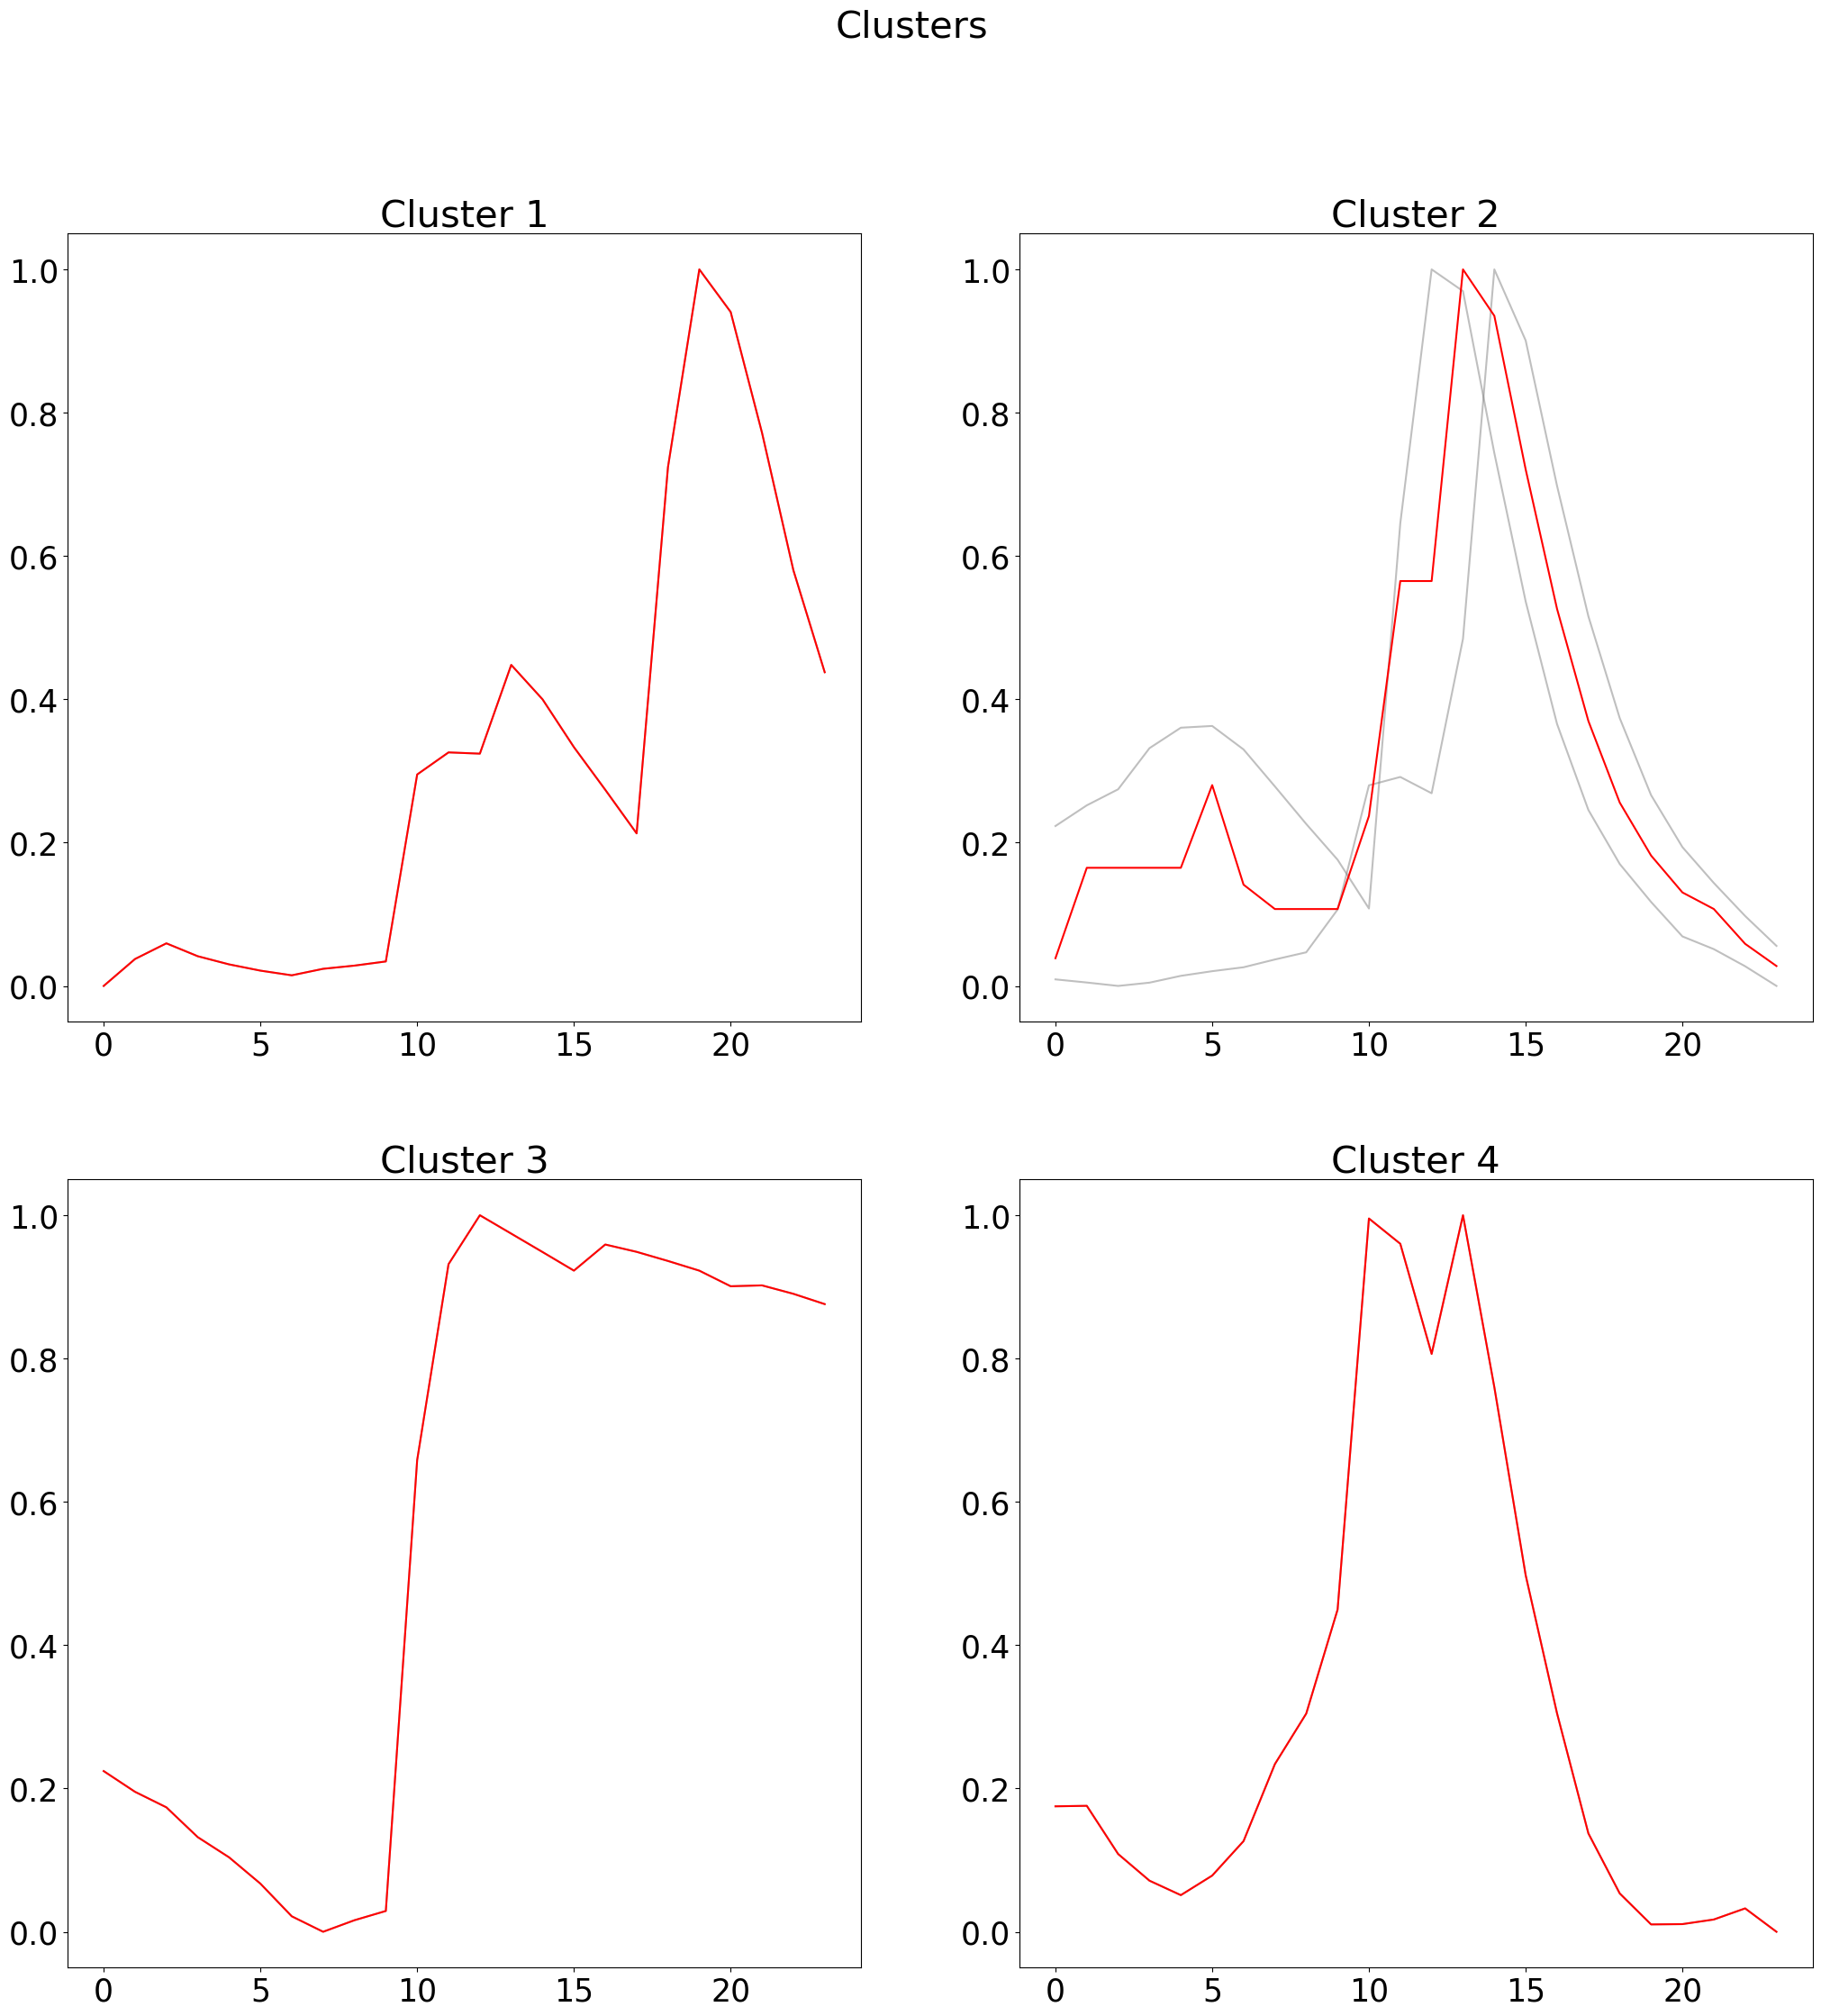

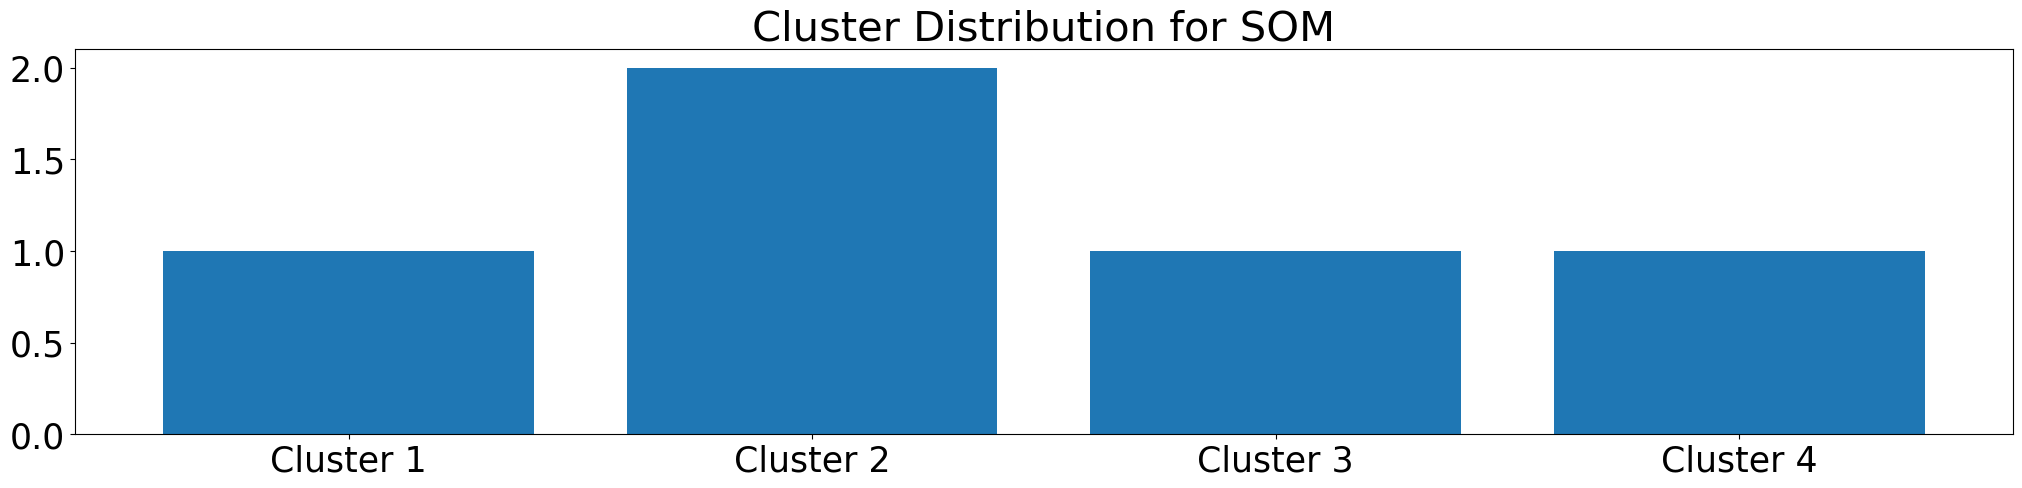

In [12]:
from Clust.clust.ML.clustering.interface import clusteringByMethod
result, figdata, figdata2 = clusteringByMethod(data, 'som',  2, 2)
plt.show()

In [13]:
result

{'2021-02-05 00:00:00': '2',
 '2021-02-06 00:00:00': '3',
 '2021-02-07 00:00:00': '2',
 '2021-02-08 00:00:00': '4',
 '2021-02-09 00:00:00': '1'}